In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from ydata_profiling import ProfileReport

%matplotlib inline

**Lectura datos limpios**

In [ ]:
# Lectura

path = 'online_news_cleaned.csv'
#path = '../data/online_news_cleaned.csv'
news_df = pd.read_csv(path)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40010 entries, 0 to 40009
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            40010 non-null  object 
 1   timedelta                      40010 non-null  float64
 2   n_tokens_title                 40010 non-null  float64
 3   n_tokens_content               40010 non-null  float64
 4   n_unique_tokens                40010 non-null  float64
 5   n_non_stop_words               40010 non-null  float64
 6   n_non_stop_unique_tokens       40010 non-null  float64
 7   num_hrefs                      40010 non-null  float64
 8   num_self_hrefs                 40010 non-null  float64
 9   num_imgs                       40010 non-null  float64
 10  num_videos                     40010 non-null  float64
 11  average_token_length           40010 non-null  float64
 12  num_keywords                   40010 non-null 

In [3]:
# Guardamos la variable categorica y trabajamos con el demas set de datos

to_predict = 'shares'
news_to_predict = news_df[[to_predict]]
news_df.drop(to_predict, axis=1, inplace=True)

news_categoric_df = news_df.select_dtypes(include=['object', 'category'])
news_numeric_df = news_df.select_dtypes(include=np.number)

news_categoric_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40010 entries, 0 to 40009
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     40010 non-null  object
dtypes: object(1)
memory usage: 312.7+ KB


### Analisis de variables numericas

In [4]:
stats_num = news_numeric_df.describe().T

# Anadimos curtosis y asimetria

stats_num['skew'] = news_numeric_df.skew()
stats_num['kurtosis'] = news_numeric_df.kurtosis()

In [5]:
cols_bin = []

# Iterar sobre cada columna en el DataFrame
cols_bin = [
    columna for columna in news_numeric_df.columns 
    if set(news_df[columna].unique()) == {0, 1}
]

print("Columnas con únicamente valores 0 y 1:")
print(cols_bin)

# Se obtienen columnas que no son binarias

cols_no_bin = [
    columna for columna in news_numeric_df.columns 
    if set(news_df[columna].unique()) != {0, 1}
]

news_numeric_bin_df = news_numeric_df[cols_bin]

Columnas con únicamente valores 0 y 1:
['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend']


In [ ]:
# EDA set de features numerico

profile = ProfileReport(
    news_numeric_df[cols_no_bin], 
    title="Minimal Profiling Report", 
    minimal=True
)
profile.to_notebook_iframe()

profile.to_file("../docs/EDA_numeric_no_binary.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 117.07it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
from ydata_profiling.model.alerts import ZerosAlert, SkewedAlert

report_obj = profile.get_description()
lista_de_alertas_completa = report_obj.alerts

# Listas donde se guardaran las columnas
cols_con_ceros = []
cols_sesgadas = []

# Guardar solo columnas
for alerta in lista_de_alertas_completa:
    if isinstance(alerta, ZerosAlert):
        # Añadir solo el atributo .column_name a la lista
        cols_con_ceros.append(alerta.column_name)
    elif isinstance(alerta, SkewedAlert):
        # Añadir solo el atributo .column_name a la lista
        cols_sesgadas.append(alerta.column_name)

for col in cols_no_bin:
    if stats_num['skew'].loc[col] >2 or stats_num['skew'].loc[col] < -2:
        cols_sesgadas.append(col)

cols_sesgadas = list(set(cols_sesgadas))

# Imprimir nombres de columnas con alertas
print("Columnas con alto porcentaje de ceros:")
print(cols_con_ceros)

print("Columnas con datos muy sesgados:")
print(cols_sesgadas)

Columnas con alto porcentaje de ceros:
['n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'kw_max_min', 'kw_min_max', 'kw_min_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity']
Columnas con datos muy sesgados:
['self_reference_avg_sharess', 'kw_max_max', 'num_imgs', 'global_sentiment_polarity', 'kw_avg_min', 'num_videos', 'kw_max_avg', 'kw_min_min', 'n_non_stop_words', 'num_hrefs', 'average_token_length', 'kw_max_min', 

In [8]:
news_df_imputado = news_numeric_df[cols_no_bin].copy()

# Asimetria

skews = stats_num['skew']

# Limites IQR

Q1 = stats_num['25%']
Q3 = stats_num['75%']
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


for columna in news_df_imputado.columns:
    # Obtener los límites para la columna actual
    lim_inf = limite_inferior[columna]
    lim_sup = limite_superior[columna]

    # Identificar los outliers en la columna actual
    outliers = (news_df_imputado[columna] < lim_inf) | (news_df_imputado[columna] > lim_sup)
    
    # Si no hay outliers en esta columna, pasar a la siguiente
    if not outliers.any():
        continue

    # Decidir el valor de imputación basado en la asimetría
    if -1 <= skews[columna] <= 1:
        # Distribución NORMAL -> Usar la MEDIA
        valor_imputacion = stats_num.loc[columna, 'mean']
        metodo = "la media"
    else:
        # Distribución ASIMÉTRICA -> Usar la MEDIANA
        valor_imputacion = stats_num.loc[columna, '50%']
        metodo = "la mediana"

    news_df_imputado.loc[outliers, columna] = valor_imputacion
    
    print(f" En '{columna}' ({'Normal' if metodo == 'la media' else 'Asimétrica'}):")
    print(f" Se imputaron {outliers.sum()} outliers con el valor de {metodo} ({valor_imputacion:.2f}).")

print("\n¡Proceso de imputación completado!")

 En 'n_tokens_title' (Asimétrica):
 Se imputaron 517 outliers con el valor de la mediana (10.00).
 En 'n_tokens_content' (Asimétrica):
 Se imputaron 2114 outliers con el valor de la mediana (413.00).
 En 'n_unique_tokens' (Asimétrica):
 Se imputaron 2002 outliers con el valor de la mediana (0.54).
 En 'n_non_stop_words' (Asimétrica):
 Se imputaron 2846 outliers con el valor de la mediana (1.00).
 En 'n_non_stop_unique_tokens' (Asimétrica):
 Se imputaron 2114 outliers con el valor de la mediana (0.69).
 En 'num_hrefs' (Asimétrica):
 Se imputaron 2529 outliers con el valor de la mediana (8.00).
 En 'num_self_hrefs' (Asimétrica):
 Se imputaron 2427 outliers con el valor de la mediana (3.00).
 En 'num_imgs' (Asimétrica):
 Se imputaron 7930 outliers con el valor de la mediana (1.00).
 En 'num_videos' (Asimétrica):
 Se imputaron 3152 outliers con el valor de la mediana (0.00).
 En 'average_token_length' (Asimétrica):
 Se imputaron 2058 outliers con el valor de la mediana (4.67).
 En 'num_key

In [ ]:
profile_no_outliers = ProfileReport(
    news_df_imputado, 
    title="No outliers Cols no bin Profiling Report", 
    minimal=True
)
profile_no_outliers.to_notebook_iframe()

profile.to_file("../docs/EDA_no_outliers.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 74.26it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
from ydata_profiling.model.alerts import ConstantAlert

report_obj_no_outliers = profile_no_outliers.get_description()
lista_de_alertas_completa_no_outliers = report_obj_no_outliers.alerts

# Listas donde se guardaran las columnas
cols_constant = []

# Guardar solo columnas

for alerta in lista_de_alertas_completa_no_outliers:
    if isinstance(alerta, ConstantAlert):
        # Añadir solo el atributo .column_name a la lista
        cols_constant.append(alerta.column_name)

# Imprimir nombres de columnas con alertas
print("Columnas con valores constantes: ")
print(cols_constant)

# Eliminarlo del data frame
news_df_imputado.drop(cols_constant, axis=1, inplace=True)

for i in cols_constant:
    cols_sesgadas.remove(i)

Columnas con valores constantes: 
['kw_max_max']


In [11]:
# Transformacion columnas con asimetria

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

# Copia para seguridad
df_transformado = news_df_imputado.copy()

df_transformado[cols_sesgadas] = power_transformer.fit_transform(df_transformado[cols_sesgadas])

print(f"Columnas en la lista 'cols_sesgadas' han sido transformadas.")
print(df_transformado[cols_sesgadas].skew()) # Verificamos que el skew se ha reducido

Columnas en la lista 'cols_sesgadas' han sido transformadas.
self_reference_avg_sharess   -0.531884
num_imgs                     -0.047671
global_sentiment_polarity    -0.001331
kw_avg_min                   -0.102793
num_videos                    0.943654
kw_max_avg                    0.080201
kw_min_min                    0.905277
n_non_stop_words              0.000000
num_hrefs                    -0.000853
average_token_length         -0.000022
kw_max_min                   -0.073829
n_tokens_title               -0.011582
num_self_hrefs               -0.056317
LDA_01                        1.023359
min_positive_polarity        -0.024426
global_rate_positive_words    0.000363
kw_min_max                   -0.156542
self_reference_min_shares    -0.542121
n_non_stop_unique_tokens      0.001537
global_rate_negative_words    0.008627
max_negative_polarity        -0.003596
self_reference_max_shares    -0.455635
dtype: float64


In [12]:
df_transformado.reset_index(drop=True, inplace=True)
news_numeric_bin_df.reset_index(drop=True, inplace=True)
news_to_predict.reset_index(drop=True, inplace=True)

dataframes_a_unir = [df_transformado, news_numeric_bin_df, news_to_predict]

# Unir los DataFrames por columnas
df_final = pd.concat(dataframes_a_unir, axis=1)

print(f"DataFrames unidos. El nuevo shape es: {df_final.shape}")
df_final.head()

DataFrames unidos. El nuevo shape es: (40010, 59)


timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
0      731.0        0.809331             219.0         0.663594   
1      731.0       -0.655405             255.0         0.604743   
2      731.0       -0.655405             211.0         0.575130   
3      731.0       -0.655405             531.0         0.503788   
4      731.0        1.270471            1072.0         0.415646   

   n_non_stop_words  n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  \
0     -2.081668e-17                  1.329535  -0.746408       -0.209935   
1     -1.387779e-17                  1.071141  -1.024433       -0.849945   
2     -2.775558e-17                 -0.354287  -1.024433       -0.849945   
3      6.938894e-18                 -0.334438   0.246617       -1.714936   
4      2.081668e-17                 -1.745689   1.470182        0.317208   

   num_imgs  num_videos  ...  data_channel_is_world  weekday_is_monday  \
0  0.075272   -0.634484  ...                    0.0                1.0   
1  0.075272   -0.634484  ...                    0.0                1.0   
2  0.075272   -0.634484  ...                    0.0                1.0   
3  0.075272   -0.634484  ...                    0.0                1.0   
4  0.075272   -0.634484  ...                    0.0                1.0   

   weekday_is_tuesday  weekday_is_wednesday  weekday_is_thursday  \
0                 0.0                   0.0                  0.0   
1                 0.0                   0.0                  0.0   
2                 0.0                   0.0                  0.0   
3                 0.0                   0.0                  0.0   
4                 0.0                   0.0                  0.0   

   weekday_is_friday  weekday_is_saturday  weekday_is_sunday  is_weekend  \
0                0.0                  0.0                0.0         0.0   
1                0.0                  0.0                0.0         0.0   
2                0.0                  0.0                0.0         0.0   
3                0.0                  0.0                0.0         0.0   
4                0.0                  0.0                0.0         0.0   

   shares  
0   593.0  
1   711.0  
2  1500.0  
3  1200.0  
4   505.0  

[5 rows x 59 columns]

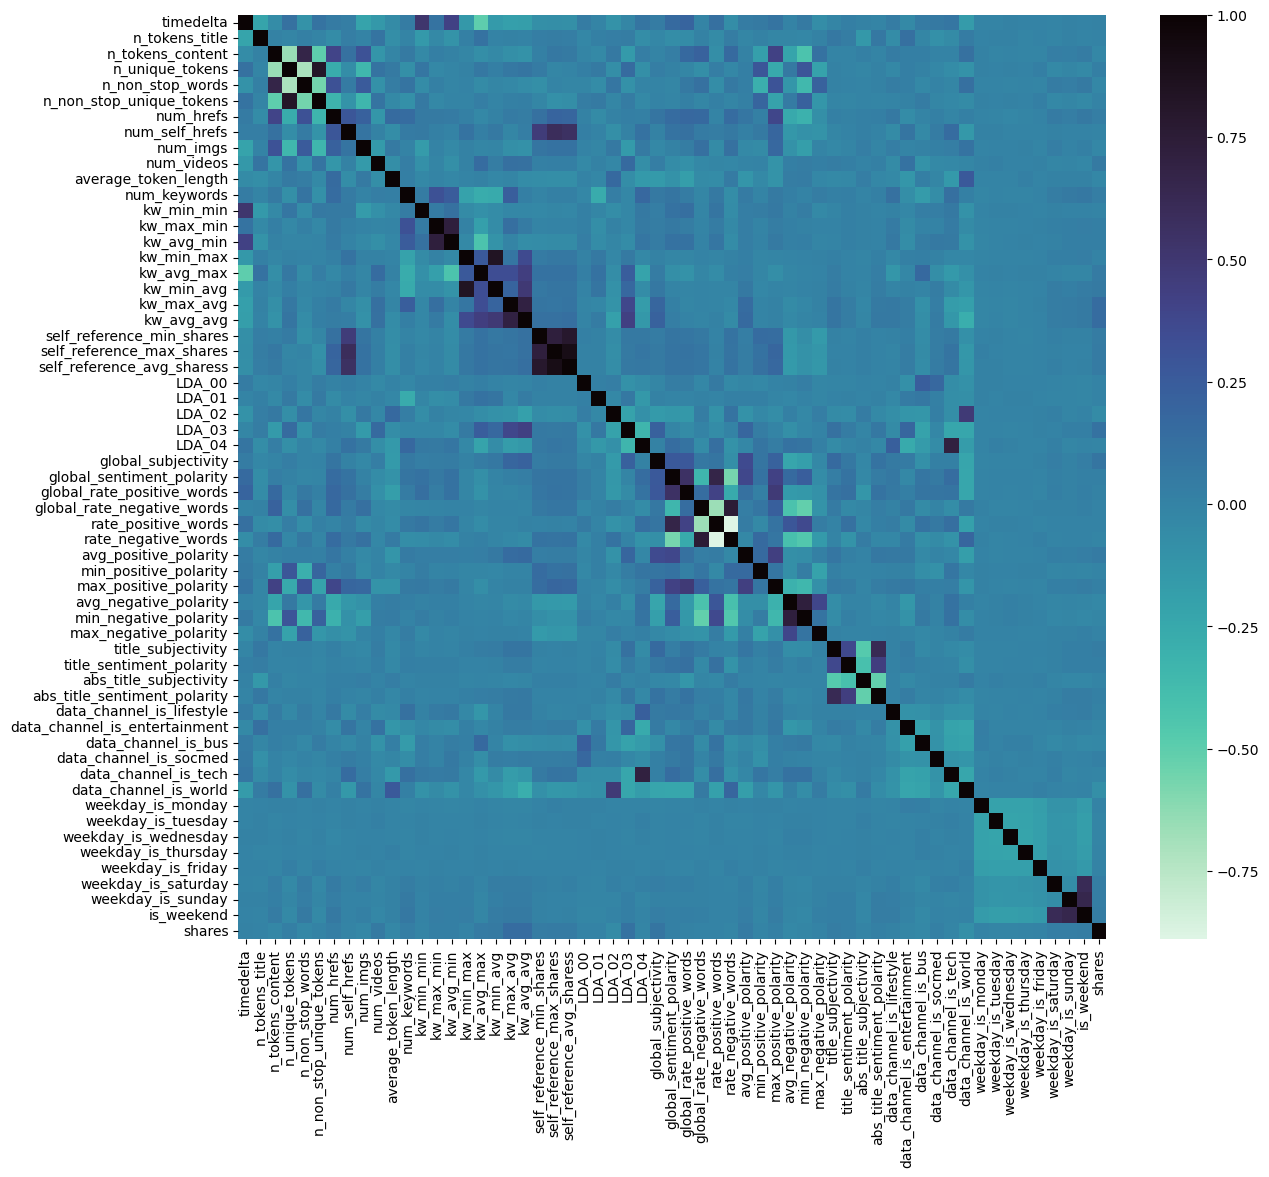

In [13]:
# Corrlacion
plt.figure(figsize = (14, 12))

sns.heatmap(df_final.corr(), cmap='mako_r')
plt.show()

In [14]:
cols_to_drop = ['kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_avg_max',
                'kw_min_avg', 'kw_max_avg', 'kw_avg_avg','min_positive_polarity', 'max_positive_polarity',
                'min_negative_polarity', 'max_negative_polarity', 'is_weekend', 'self_reference_min_shares', 
                'self_reference_max_shares']

# Eliminarlo del data frame
df_final.drop(cols_to_drop, axis=1, inplace=True)

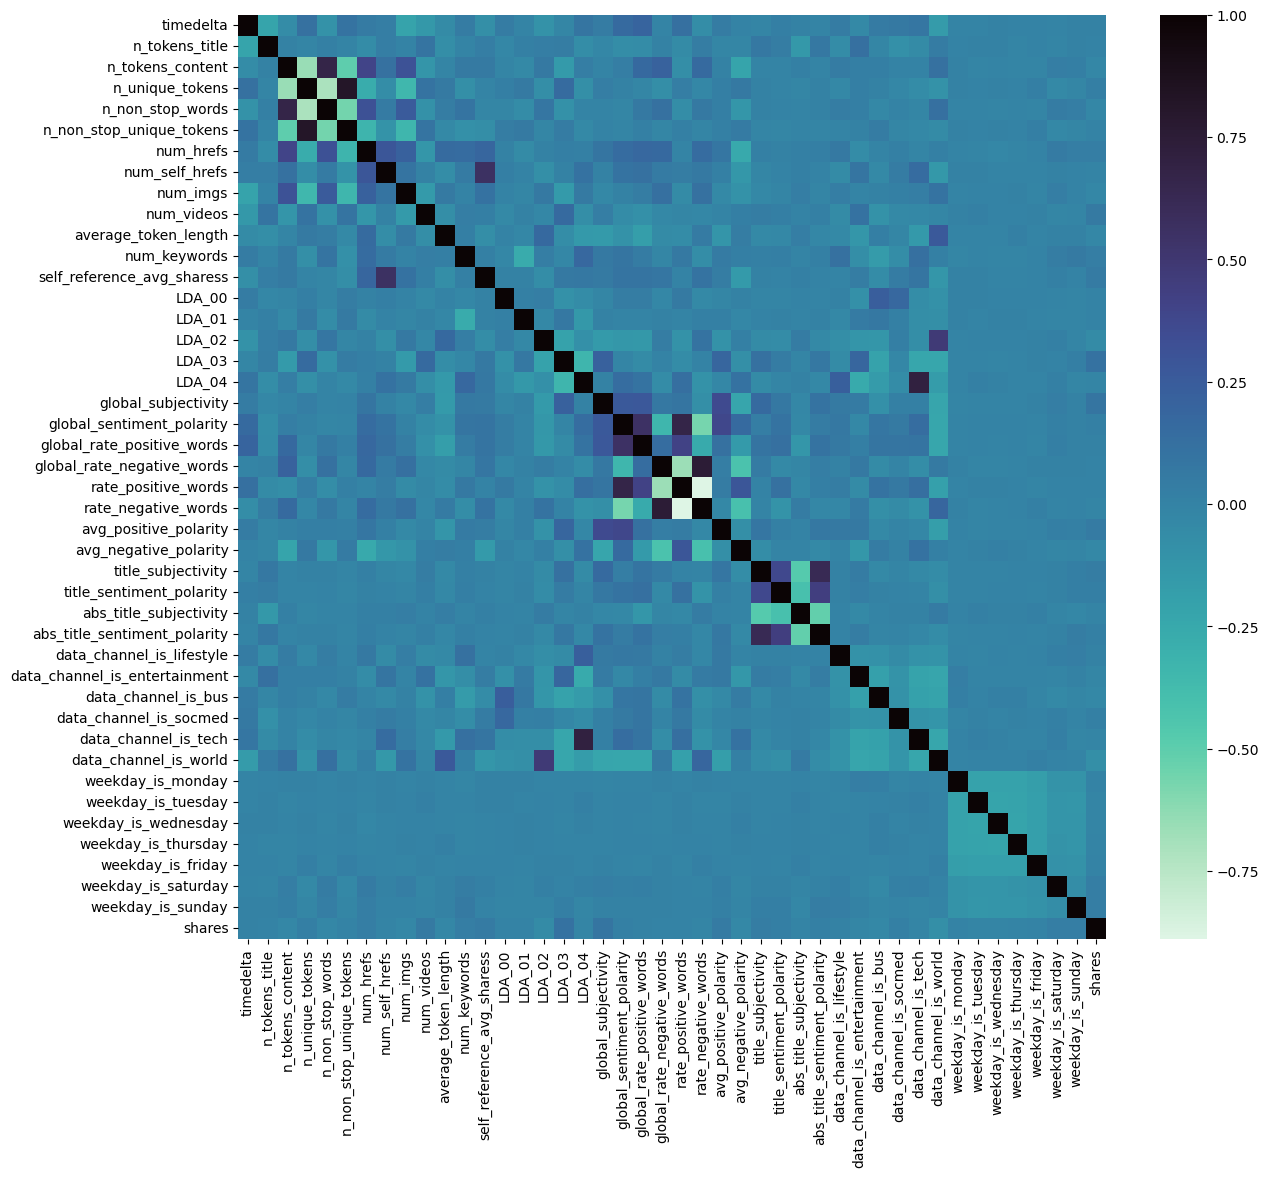

In [15]:
# Corrlacion
plt.figure(figsize = (14, 12))

sns.heatmap(df_final.corr(), cmap='mako_r')
plt.show()

In [16]:
# Escalamiento

final_scaler = StandardScaler()

df_escalado_final = pd.DataFrame(
    final_scaler.fit_transform(df_final), 
    columns=df_final.columns, 
    index=df_final.index
)

df_escalado_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40010 entries, 0 to 40009
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      40010 non-null  float64
 1   n_tokens_title                 40010 non-null  float64
 2   n_tokens_content               40010 non-null  float64
 3   n_unique_tokens                40010 non-null  float64
 4   n_non_stop_words               40010 non-null  float64
 5   n_non_stop_unique_tokens       40010 non-null  float64
 6   num_hrefs                      40010 non-null  float64
 7   num_self_hrefs                 40010 non-null  float64
 8   num_imgs                       40010 non-null  float64
 9   num_videos                     40010 non-null  float64
 10  average_token_length           40010 non-null  float64
 11  num_keywords                   40010 non-null  float64
 12  self_reference_avg_sharess     40010 non-null 

In [17]:
df_preprocess = pd.concat([news_categoric_df, df_escalado_final], axis=1)

df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40010 entries, 0 to 40009
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            40010 non-null  object 
 1   timedelta                      40010 non-null  float64
 2   n_tokens_title                 40010 non-null  float64
 3   n_tokens_content               40010 non-null  float64
 4   n_unique_tokens                40010 non-null  float64
 5   n_non_stop_words               40010 non-null  float64
 6   n_non_stop_unique_tokens       40010 non-null  float64
 7   num_hrefs                      40010 non-null  float64
 8   num_self_hrefs                 40010 non-null  float64
 9   num_imgs                       40010 non-null  float64
 10  num_videos                     40010 non-null  float64
 11  average_token_length           40010 non-null  float64
 12  num_keywords                   40010 non-null 

In [ ]:
df_preprocess.to_csv('../data/online_news_preprocess.csv')